# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)


## Typical architecture of a classification neural network

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

Table 1: Typical architecture of a classification network. Source: Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

In [1]:
import tensorflow as tf
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd 



## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our own classification data.

> 🔑 **Note:** It's a common practice to get you and model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.



In [2]:
# Make 1000 examples
n_samples = 1000
# Create samples
X,y = make_circles(n_samples, noise=0.03, random_state=42 )

In [3]:
#transforming data into a dataframe
circles = pd.DataFrame({'X0': X[:, 0], 'X1': X[:, 1], 'label': y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


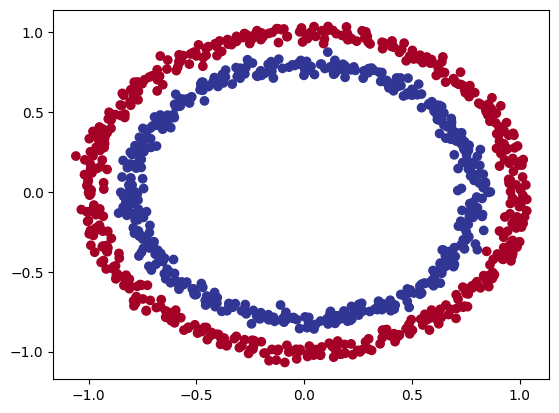

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu )
plt.show()

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> 🛠 **Practice:** Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

In [5]:
# Check the shapes of features and labels
X.shape, y.shape

((1000, 2), (1000,))

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`).

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [6]:
tf.random.set_seed(42)

model = tf.keras.Sequential(
    tf.keras.layers.Dense(1)
)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)
model.fit(X,y, epochs=5 ,verbose=0)
model.evaluate(X,y)




32/32 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5040


[0.6941081285476685, 0.5040000081062317]

The model sounds like guessing, because its accuracy is getting around ~50%. So We need to improve the model performing

In [7]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, ),
    tf.keras.layers.Dense(10, ),
    tf.keras.layers.Dense(1,   )
])
# changing the optimizer to Adam
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
## adding more epochs to train the modal
model_2.fit(X,y, epochs=100 ,verbose=0)
model_2.evaluate(X,y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.5070


[0.6960955858230591, 0.5070000290870667]

to visualize our model's predictions, let's create a function `plot_decision_boundary`, this function will:

* Take in a trained model, features (X) and labels (y)
* Create a mashgrid of the different X values
* Make predictions across the meshgrid
* Plot the predictions as well as a line between zones (where  each unique class falls)



Still!

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 **Note:** Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **visualize, visualize, visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 **Note:** If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [8]:
import numpy as np

In [9]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

 90/313 [=======>......................] - ETA: 1s

313/313 [==============================] - 2s 3ms/step
doing binary classifcation...


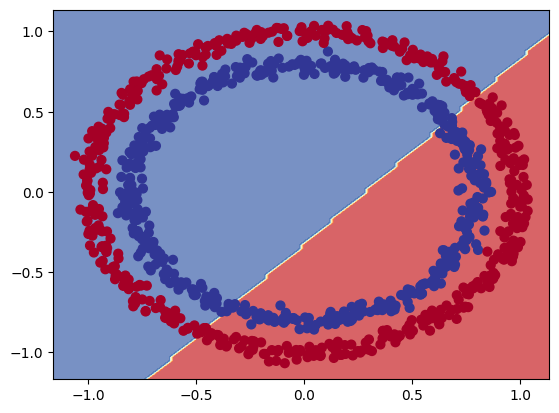

In [10]:
plot_decision_boundary(model_2,X,y)

In [11]:
# nx, ny = (3, 3)
# x = np.linspace(0, 1, nx)
# y = np.linspace(0, 1, ny)
# xv, yv = np.meshgrid(x, y)
# print(x)
# print(y ,'\n')
# print(xv)
# print(yv ,'\n')
# print(xv.ravel())
# print(yv.ravel(), '\n') 
# print(np.c_[xv, yv])



### Missing Piece: Non-linearity

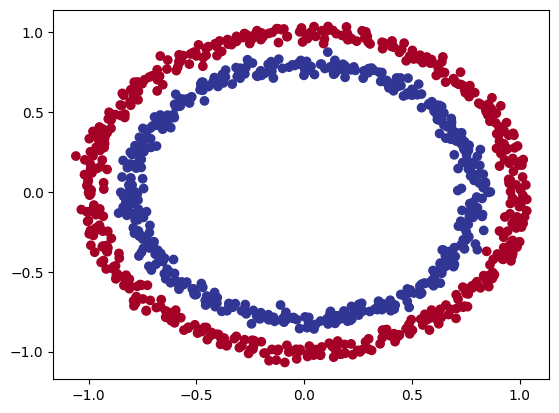

In [12]:
# Check out our data
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu )

In [13]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='linear' ),
])
# changing the optimizer to Adam
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_3.fit(X,y, epochs=100 ,verbose=0)
model_3.evaluate(X,y)

32/32 [==============================] - 0s 3ms/step - loss: 2.9123 - accuracy: 0.4860


[2.9122941493988037, 0.4860000014305115]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


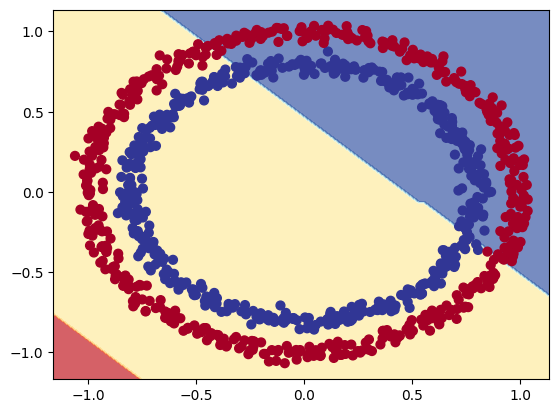

In [14]:
plot_decision_boundary(model_3, X, y)

lets try to create a our first neural network with a non-linear activation function. Use TF.playground to check out how to change hyperparameters can help us to find the best model

In [15]:
tf.random.set_seed(42)

## changing the activation function
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='relu'  ),
])
# changing the optimizer to Adam
model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_4.fit(X,y, epochs=100 ,verbose=0)
model_4.evaluate(X,y)

32/32 [==============================] - 0s 3ms/step - loss: 0.8232 - accuracy: 0.4780


[0.8231645226478577, 0.4779999852180481]

  1/313 [..............................] - ETA: 31s

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


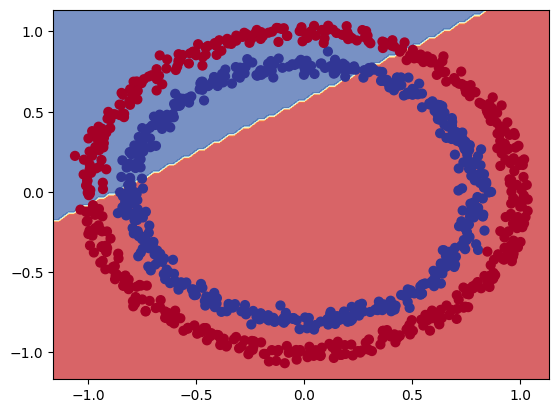

In [16]:
plot_decision_boundary(model_4, X, y)

In [17]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1,  ),
])
# changing the optimizer to Adam
model_5.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_5.fit(X,y, epochs=100 ,verbose=1)
model_5.evaluate(X,y)

Epoch 1/100
32/32 [==============================] - 2s 3ms/step - loss: 0.9642 - accuracy: 0.3730
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8679 - accuracy: 0.4090
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8437 - accuracy: 0.4010
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8274 - accuracy: 0.4030
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8140 - accuracy: 0.3930
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8019 - accuracy: 0.3870
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7913 - accuracy: 0.3990
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7824 - accuracy: 0.3920
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7738 - accuracy: 0.3780
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7659 - accuracy: 0.3480
Epoch 11/

[0.4145856201648712, 0.8610000014305115]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


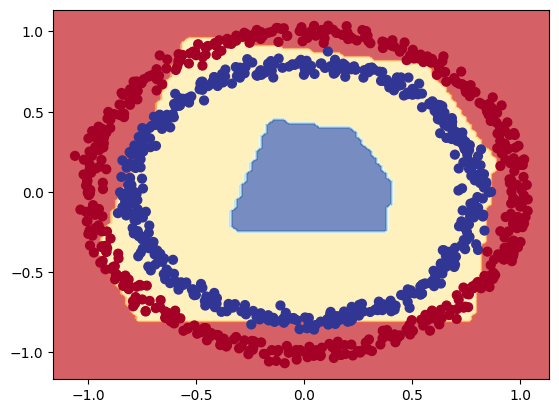

In [18]:
plot_decision_boundary(model_5, X, y)

What gives?

It seems like our model is the same as the one in the TensorFlow Playground but model it's still drawing straight lines...

Ideally, the yellow lines go on the inside of the red circle and the blue circle.

Okay, okay, let's model this circle once and for all.

One more model (I promise... actually, I'm going to have to break that promise... we'll be building plenty more models).

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the Sigmoid activation function.

In [19]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'  ),
])
# changing the optimizer to Adam
model_6.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_6.fit(X,y, epochs=100 ,verbose=1)
model_6.evaluate(X,y)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 0.6905 - accuracy: 0.5050
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5160
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5250
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5190
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.5210
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5290
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5330
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5400
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5450
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5460
Epoch 11/

[0.29496875405311584, 0.9800000190734863]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


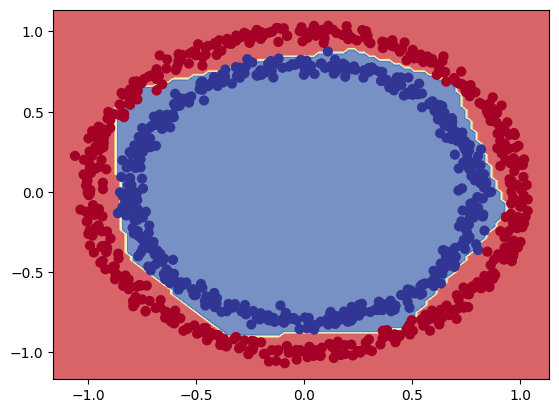

In [20]:
plot_decision_boundary(model_6, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **question**: what's wrong the predictions we've made? Are we really evaluating our model correctly? Hint: what data did the modal learn on and what data did we predict on?
* Answer**: we don't separate train and test data

> 🔑 **Note**: The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neurals networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.


In [21]:
# Create a toy a tensor (similar to the data we pass into our models)
A = tf.cast(tf.range(-10,10 ), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

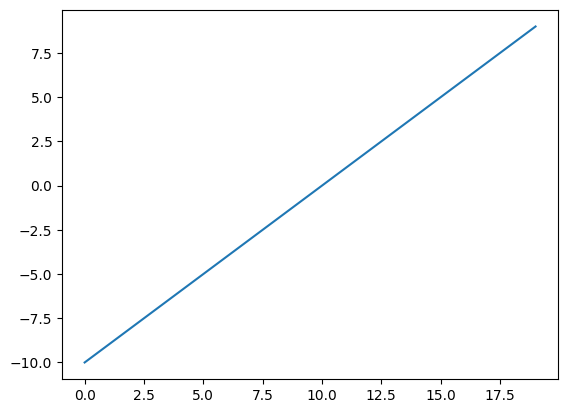

In [22]:
# Visualize our toy tensor
plt.plot(A)
plt.show()

Let's start by replicating sigmoid -  `sigmoid(x) = 1 / (1 + exp(-x))`

In [23]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x)) 

# use your sigmoid fuction on our tensor
sigmoid(A)


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397872e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726233e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105860e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

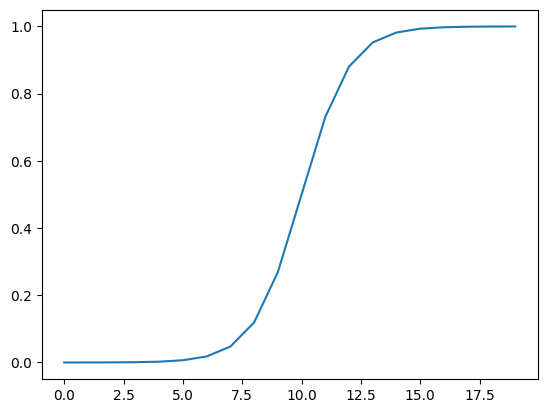

In [24]:
# Plot A tensor transformed by sigmoid
plt.plot(sigmoid(A))
plt.show()

Let's recreate the relu function `relu(x) = max(x,0)`

In [25]:
def relu(x):
    return tf.maximum(x,0)
# use your relu fuction on our tensor
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

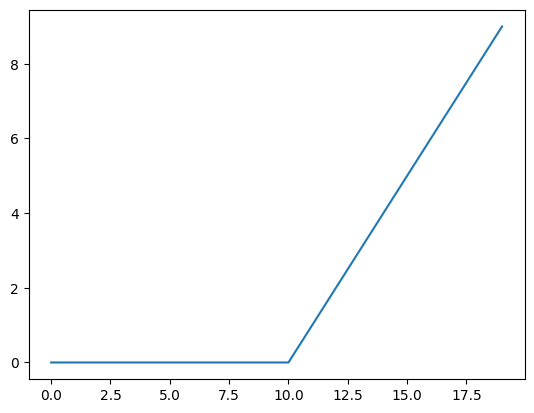

In [26]:
plt.plot(relu(A))
plt.show()

## Step 3: test your model

Lets check out our model performing with test data

In [27]:
X_train, y_train  = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [28]:
tf.random.set_seed(42)

## Create the model (same as model_6)
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
# changing the optimizer to Adam and learning rate
model_7.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)
## reducing the number of epochs 
history = model_7.fit(X_train,y_train, epochs=25 ,verbose=1)

## evalute the modelon test dataset
model_7.evaluate(X_test,y_test)

Epoch 1/25


25/25 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5000
Epoch 3/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5587
Epoch 4/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5263
Epoch 5/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5387
Epoch 6/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.5775
Epoch 7/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6504 - accuracy: 0.6913
Epoch 8/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6241 - accuracy: 0.7275
Epoch 9/25
25/25 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.8288
Epoch 10/25
25/25 [==============================] - 0s 4ms/step - loss: 0.5297 - accuracy: 0.9175
Epoch 11/25
25/25 [===========

[0.0775403305888176, 0.9850000143051147]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...
313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


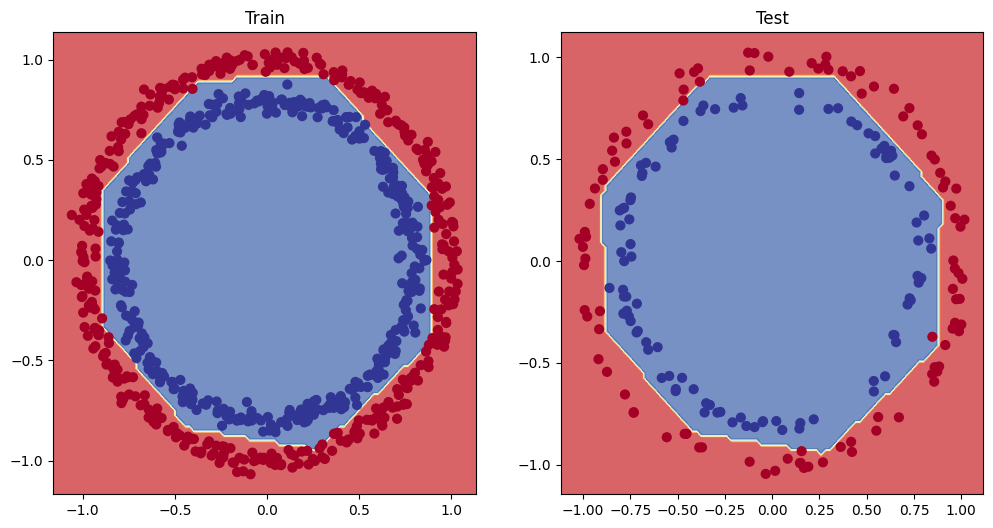

In [29]:
#lets check the differences between training and text data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_7, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_7, X_test, y_test)
plt.show()


## Step 4: Show the results

In [30]:
## convert the history object into a Dataframe
pd.DataFrame(history.history)

,loss,accuracy
0,0.695018,0.50000
1,0.692653,0.50000
2,0.689467,0.55875
3,0.685684,0.52625
4,0.679352,0.53875
5,0.668867,0.57750
6,0.650354,0.69125
7,0.624141,0.72750
8,0.581114,0.82875
9,0.529716,0.91750


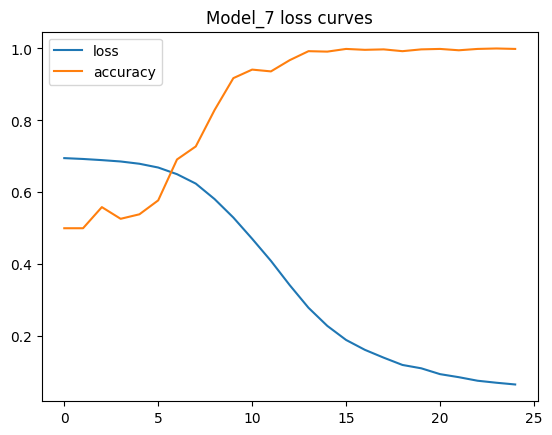

In [31]:
# plot the model 7 performing
pd.DataFrame(history.history).plot()
plt.title("Model_7 loss curves")
plt.show()

🔑 **Note**: for many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to ground truth labels)

### finding the best learning rate 

To find the ideal learning rate (the learning rate where the loss decreases the most during training) we're going to use the following steps:
* A learning rate **callback** - you can think a callback as an extra piece funcionality, you can add do your model *while* its training
* Another model (we could use the same one as above, but we're practing building models here)
* A modified loss curves plot

In [32]:
tf.random.set_seed(42)

## Create the model (same as model_7)
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'  ),
])

model_8.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

#Create a learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch/20))

history_8 = model_8.fit(X_train,y_train, epochs=100 ,verbose=1, callbacks=lr_scheduler)

model_8.evaluate(X_test,y_test)


Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5075 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5150 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5175 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5188 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5175 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5200 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5213 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5200 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss

[0.6934308409690857, 0.4950000047683716]

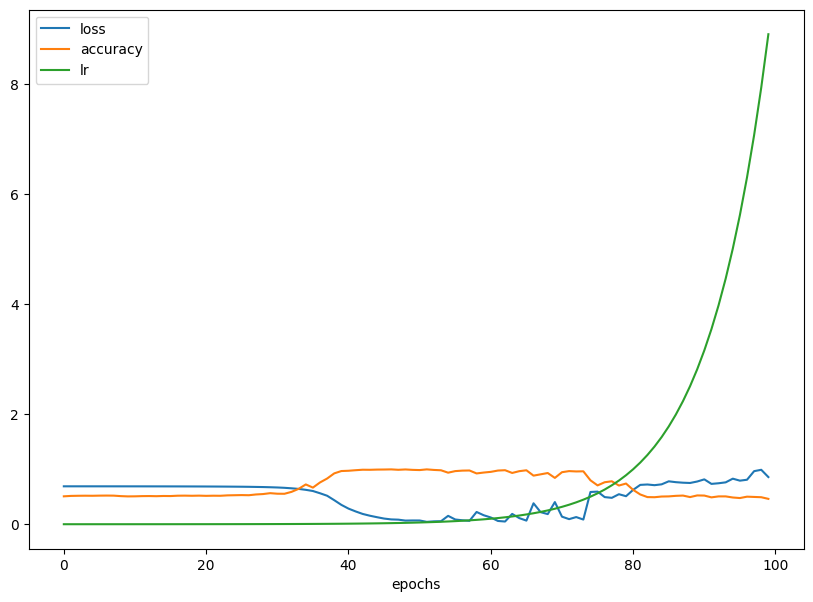

In [33]:
pd.DataFrame(history_8.history).plot(figsize=(10,7), xlabel="epochs")
plt.show()

As you you see the learning rate exponentially increases as the number of epochs increases.

And you can see the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

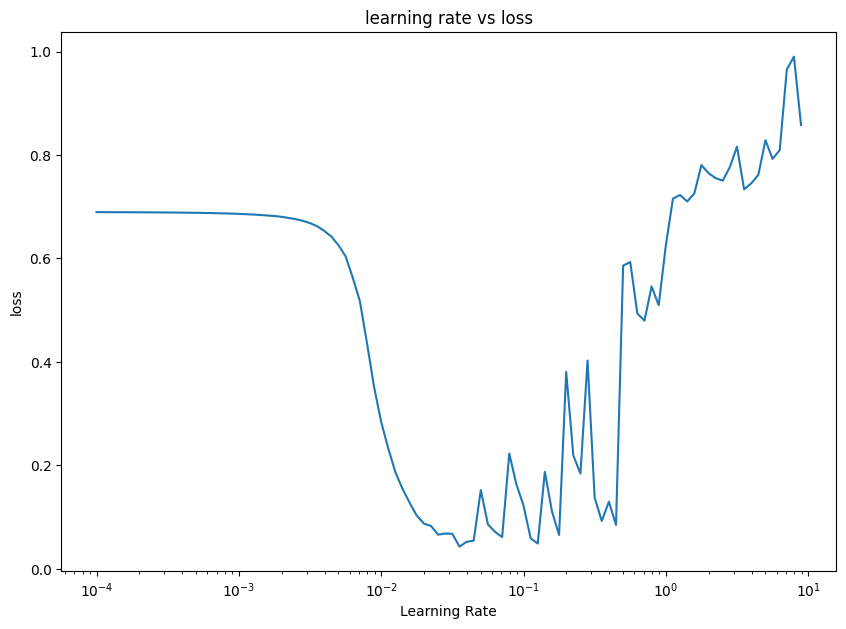

In [34]:
#plot the learning rate versus the loss
lrs = 1e-4  * (10 ** (tf.range(100)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_8.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('loss')
plt.title('learning rate vs loss')
plt.show()

To figure out the ideal value of the learning rate (at least the ideal value to begin training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between 0.01 (
) and 0.02.

In [35]:
## Let's try  using a higher *ideal learning rate with the same modal as before

tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'  ),
])

model_9.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    metrics=['accuracy']
)

history_9 = model_9.fit(X_train,y_train, epochs=20 ,verbose=1)

model_9.evaluate(X_test,y_test)

Epoch 1/20


25/25 [==============================] - 1s 4ms/step - loss: 0.6828 - accuracy: 0.5800
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.5750
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6502 - accuracy: 0.6087
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.6775
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.7663
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.8850
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.3418 - accuracy: 0.9225
Epoch 8/20
25/25 [==============================] - 0s 7ms/step - loss: 0.2646 - accuracy: 0.9463
Epoch 9/20
25/25 [==============================] - 0s 3ms/step - loss: 0.2066 - accuracy: 0.9787
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9800
Epoch 11/20
25/25 [===========

[0.051417917013168335, 0.9900000095367432]

Nice! With a little higher learning rate (0.02 instead of 0.01) we reach a higher accuracy than `model_7` in less epochs (20 
instead of 25).
> 🛠 Practice: Now you've seen an example of what can happen when you change the learning rate, try changing the learning rate value in the TensorFlow Playground and see what happens. What happens if you increase it? What happens if you decrease it?


313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


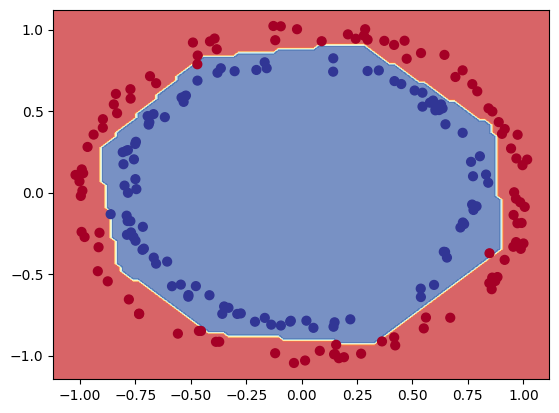

In [36]:
plot_decision_boundary(model_9,X_test,y_test)

In [37]:
## compore the 2 best models
print(model_7.evaluate(X_test,y_test))
print(model_9.evaluate(X_test,y_test))

7/7 [==============================] - 0s 3ms/step - loss: 0.0775 - accuracy: 0.9850
[0.0775403305888176, 0.9850000143051147]
7/7 [==============================] - 0s 3ms/step - loss: 0.0514 - accuracy: 0.9900
[0.051417917013168335, 0.9900000095367432]


313/313 [==============================] - 1s 2ms/step
doing binary classifcation...
313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


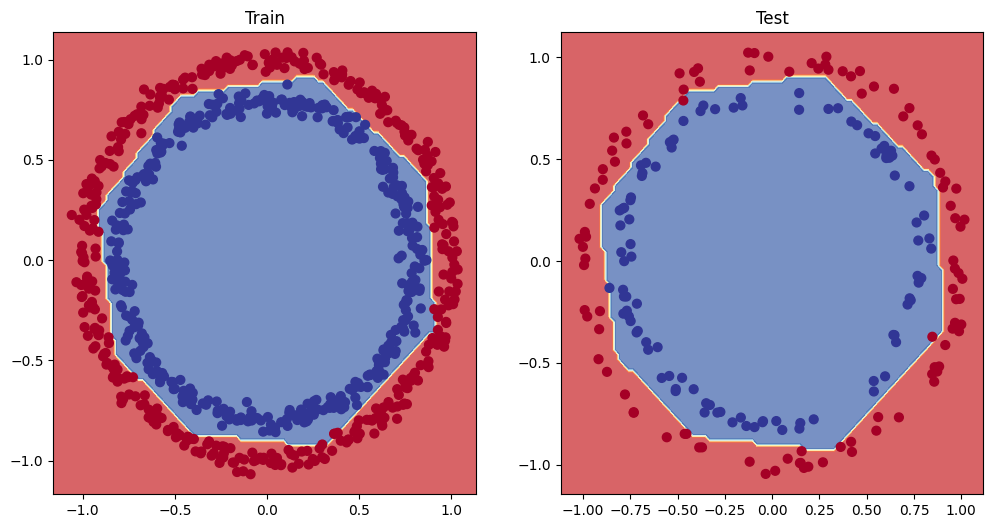

In [38]:
#lets check the differences between training and text data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_9, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_9, X_test, y_test)
plt.show()


And as we can see, almost perfect again.

These are the kind of experiments you'll be running often when building your own models.

Start with default settings and see how they perform on your data.

And if they don't perform as well as you'd like, improve them.

Let's look at a few more ways to evaluate our classification models.



### More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Note:** Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [39]:
# Check the accuracy of our model
loss, accuracy = model_9.evaluate(X_test, y_test)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

1/7 [===>..........................] - ETA: 0s - loss: 0.0745 - accuracy: 0.9688

7/7 [==============================] - 0s 3ms/step - loss: 0.0514 - accuracy: 0.9900
Model loss on test set: 0.051417917013168335
Model accuracy on test set: 99.00%


In [40]:
# Make predictions
y_preds = model_9.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [41]:
# View the first 10 predictions
y_preds[:10]
     

array([[0.97137475],
       [0.97189194],
       [0.96388954],
       [0.97189194],
       [0.04703728],
       [0.00192338],
       [0.9253511 ],
       [0.00221037],
       [0.97189194],
       [0.14881715]], dtype=float32)

In [42]:
# View the first 10 test labels
y_test[:10]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])
It looks like we need to get our predictions into the binary format (0 or 1).

But you might be wondering, what format are they currently in?

In their current format (9.8526537e-01), they're in a form called prediction probabilities.

You'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how likely they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (y_test) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using tf.round().

In [43]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Create confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

array([[99,  2],
       [ 0, 99]], dtype=int64)

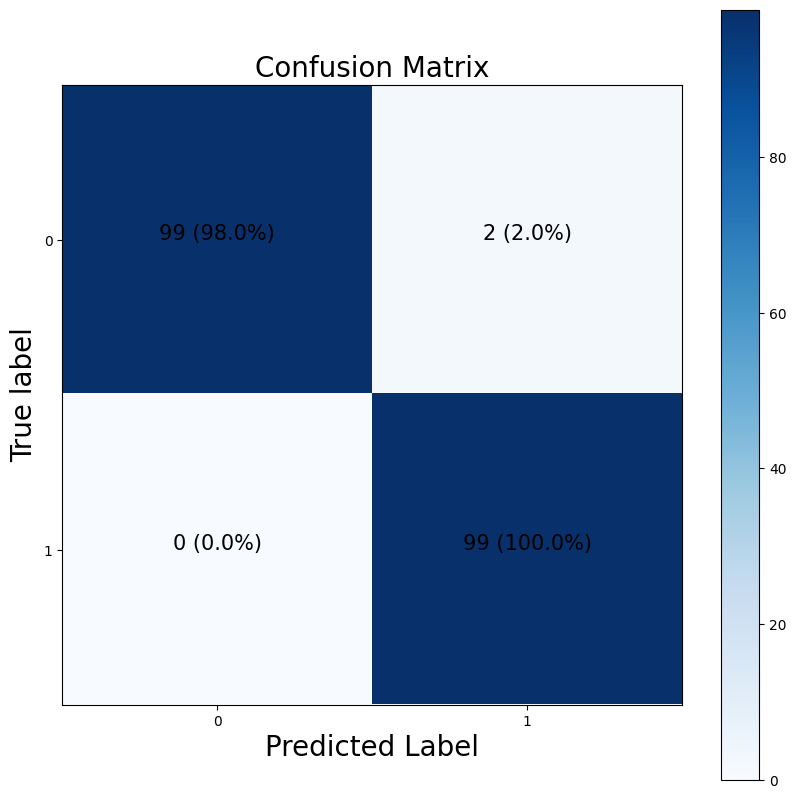

In [56]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.i

import itertools

figsize = (10,10)

# Create a confision matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
n_classes =  cm.shape[0]

# Let's create a prettify it
fig, ax = plt.subplots(figsize=figsize)

# Create a matrixplot 
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
    labels = classes
else:
    labels = np.arange(cm.shape[0])
    
# Label the axes
ax.set(
    title="Confusion Matrix",
    xlabel='Predicted Label',
    ylabel='True label',
    xticks=np.arange(n_classes),
    yticks=np.arange(n_classes),
    xticklabels=labels,
    yticklabels=labels,
)

# Set x-axis labels to botom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size 
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.title.set_size(20)

# Set a threshold for different colors
threshold = (cm.max() + cm.min() / 2)

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]) ):
    plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j] * 100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i,j] > threshold else "black",
             size=15
             )

In [48]:
cm_norm

array([[0.98019802, 0.01980198],
       [0.        , 1.        ]])